## COVID-19 country comparison

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports.

Shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).

In [28]:
# Builtins
import datetime
import math
from io import StringIO

# Third party modules
import requests
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display, Markdown
import numpy as np
import scipy.optimize

register_matplotlib_converters()
light_grey = (.85, .85, .85, 1) 
matplotlib.rcParams['figure.figsize'] = (14, 8)        # Default size of all figures
matplotlib.rcParams['axes.facecolor'] = light_grey     # Default background color of all graph areas
matplotlib.rcParams['figure.facecolor'] = light_grey   # Default background color of all figure borders
cm = plt.cm.get_cmap('nipy_spectral')                  # This colormap is used for the colors of the plot lines

# Where to get the data. There have been some issues with the data quality lately. 
# For the most recent data, use branch 'master'.
# For stable March 11 data, use '82e1397911272be823cb93cbc19b62551608b8dc'
branch = "master" 
base_url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/{branch}/csse_covid_19_data/csse_covid_19_time_series/"
data_urls = {
    "confirmed": "time_series_19-covid-Confirmed.csv",
    "deaths":    "time_series_19-covid-Deaths.csv",
    "recovered": "time_series_19-covid-Recovered.csv"    
}

# Convenience function for labelling the y-axis
def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a set of Pandas dataframes

Show the first few rows of the confirmed cases dataframe for illustration.

In [29]:
# Set up a dictionary to store all the data in
dataframes = {}
for metric in data_urls.keys():
    url = base_url + data_urls[metric]                             # Combine URL parts
    r = requests.get(url)                                          # Retrieve from URL
    dataframes[metric] = pd.read_csv(StringIO(r.text), sep=",")    # Convert into Pandas dataframe
    
# Display the first lines
pd.set_option('display.max_rows', 500)
dataframes["confirmed"].iloc[:10,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,47,48,50,50,50,53,59,70,75
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,331,360,420,461,502,511,581,639,639,701
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,117,130,138,150,150,160,178,178,200
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,50,83,93,99,117,129,149,149,197
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,12,13,21,21,27,32,32,39,46,64
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,22,22,26,28,38,48,55,65,65,92
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,10,10,10,11,11,15,18,21,21,36
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,11,13,13,13,15,15,18,20,20,35
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,1,1,1,1,2,2,2,3,3,5


### Process and add up all provinces/states into one row per country 

In [30]:
for metric in data_urls.keys():
    by_country = dataframes[metric].groupby("Country/Region").sum()           # Group by country
    dates = by_country.columns[2:]                                            # Drop Lat/Long columns
    by_country.loc["All except China", dates] =\
        by_country.sum().loc[dates]-by_country.loc["China", dates]   # Add "Outside China" row
    by_country = by_country.loc[:, dates].astype(int)                         # Convert to columns to matplotlib dates
    dates = pd.to_datetime(dates)
    by_country.columns = dates

    if metric == "confirmed":
        # Add in some data points for China from before the start of the Johns Hopkins data.
        # Source: https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020
        early_china_data = {
            "1/17/20": 45,
            "1/18/20": 62,
            "1/20/20": 218
        }
        for d, n in early_china_data.items():
            by_country.loc["China", pd.to_datetime(d)] = n               # Insert early China data point
        by_country = by_country.reindex(list(sorted(by_country.columns)), axis=1) # Retain chronological column order  
        by_country = by_country.fillna(0)
        
        # Correct an odd blip in the Japanese data. 
        # From 2/5 to 2/7, the Johns Hopkins data for Japan goes 22, 45, 25. 
        # I assume that the 45 is incorrect.
        by_country.loc["Japan", pd.to_datetime("2/06/20")] = 23.5      #  Halfway between values for 2/5 and 2/7
        
    by_country = by_country.rename(index={"Republic of Korea": "South Korea", # Change some weird formal names to
                                          "Holy See": "Vatican City",         # more commonly used ones
                                          "Iran (Islamic Republic of)": "Iran",
                                          "Viet Nam": "Vietnam",
                                          "Taipei and environs": "Taiwan",
                                          "Republic of Moldova": "Moldova",
                                          "Russian Federaration": "Russia",
                                          "Others": "Cruise Ship",            # By popular request
                                          "Korea, South": "South Korea",
                                          "Taiwan*": "Taiwan"
                                         })        
        
    dataframes[metric+"_by_country"] = by_country
    
confirmed_by_country = dataframes["confirmed_by_country"]              # Shorthand

with pd.option_context("display.max_rows", 10, "display.max_columns", 10):
    display(dataframes["confirmed_by_country"])

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13
Country/Region,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0,0,...,4,5,7,7,7
Albania,0.0,0.0,0.0,0,0,...,2,10,12,23,33
Algeria,0.0,0.0,0.0,0,0,...,20,20,20,24,26
Andorra,0.0,0.0,0.0,0,0,...,1,1,1,1,1
Antigua and Barbuda,0.0,0.0,0.0,0,0,...,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,0.0,0.0,0.0,0,0,...,1,1,1,1,3
United Arab Emirates,0.0,0.0,0.0,0,0,...,45,74,74,85,85
United Kingdom,0.0,0.0,0.0,0,0,...,322,384,459,459,801


### List all countries in the `by_country` table

In [31]:
print(f"{len(confirmed_by_country)} countries/territories affected:\n")
for i, k in enumerate(confirmed_by_country.index):
    if len(k) > 19:
        k = k[:18] + "."
    print(f"{k:20}", end=" " if (i+1) % 5 else "\n")      # Every 5 items, end with a newline

126 countries/territories affected:

Afghanistan          Albania              Algeria              Andorra              Antigua and Barbuda 
Argentina            Armenia              Aruba                Australia            Austria             
Azerbaijan           Bahrain              Bangladesh           Belarus              Belgium             
Bhutan               Bolivia              Bosnia and Herzego.  Brazil               Brunei              
Bulgaria             Burkina Faso         Cambodia             Cameroon             Canada              
Cayman Islands       Chile                China                Colombia             Congo (Kinshasa)    
Costa Rica           Cote d'Ivoire        Croatia              Cruise Ship          Cuba                
Cyprus               Czechia              Denmark              Dominican Republic   Ecuador             
Egypt                Estonia              Ethiopia             Finland              France              
French Guiana     

In [32]:
def plot(x_metric, y_metric, countries_to_plot, markers="o.^v<>sXD*,", colormap=cm, 
         use_log_scale=True, min_cases=40, n_days_average=5):
    short_metric_to_long = {
        "confirmed": "Confirmed cases",
        "deaths":    "Deaths",
        "active":    "Active cases",
        "growth_factor": f"{n_days_average}-day-average growth factor"
    }
    fills = ["none", "full"]
    length = None
    m = len(markers)
    cm = plt.cm.get_cmap(colormap)
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=len(countries_to_plot))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    if y_metric in dataframes:
        by_country   = dataframes[y_metric+"_by_country"]
    elif y_metric == "growth_factor":
        by_country   = dataframes["confirmed_by_country"]
    elif y_metric == "active":
        by_country = dataframes["confirmed_by_country"] - \
                     dataframes["deaths_by_country"] - \
                     dataframes["recovered_by_country"] 
    else:
        print(f"{y_metric}' is an invalid y_metric!")
        
    for i, country in enumerate(countries_to_plot):
        country_data = by_country.loc[country] # , dates]
        fill = fills[i % (2*len(markers)) < len(markers)]
        
        if y_metric == "growth_factor":
            if x_metric == "day_number":
                country_data = country_data[country_data >= min_cases]
            country_data = country_data.diff() / country_data + 1
            country_data = np.convolve(country_data, np.ones(n_days_average)/n_days_average, mode="valid")
            
        is_valid = sum(np.nan_to_num(country_data)) > 0
        
        if x_metric == "calendar_date" and is_valid:
            plt.plot(country_data, markers[i%m]+"-", label=country, 
                 markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
            
        elif x_metric == "day_number":                   
            if y_metric != "growth_factor":
                country_data = country_data[country_data >= min_cases]
            if country == "Outside China":
                length = len(country_data)
            day_nr = list(range(len(country_data)))
            if is_valid:
                plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, 
                         markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
      
    long_y_metric = short_metric_to_long[y_metric]
    plt.ylabel(long_y_metric, fontsize=14)
    if x_metric == "calendar_date":
        plt.xlabel("Date", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric} over time in selected countries", fontsize=18)
        plt.ylim(0.9*use_log_scale, by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
        firstweekday = pd.Timestamp(country_data.index[0]).dayofweek
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1, byweekday=firstweekday))
    elif x_metric == "day_number":
        if y_metric != "growth_factor":        
            floor = 10**math.floor(math.log(min_cases)/math.log(10))
            floor = floor * (1 - (not use_log_scale))  * .9
            ceil  = 10**math.ceil(math.log(by_country.loc[countries_to_plot].max().max())/math.log(10))
            ceil  = ceil * 1.2
            plt.ylim(floor, ceil)            
        plt.xlim(0, length)
        plt.xlabel("Day Number", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric}, from the first day with ≥{min_cases} local cases,in selected countries", 
                  fontsize=18)
        
    plt.legend()
    if y_metric == "growth_factor":
        plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.2f}"))
        plt.ylabel("Growth Factor", fontsize=14)
    else:
        set_y_axis_format(use_log_scale)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().tick_params(which="minor", width=0)
    plt.gca().tick_params(which="major", color=light_grey)    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()

### Plot cases over calendar date in selected countries

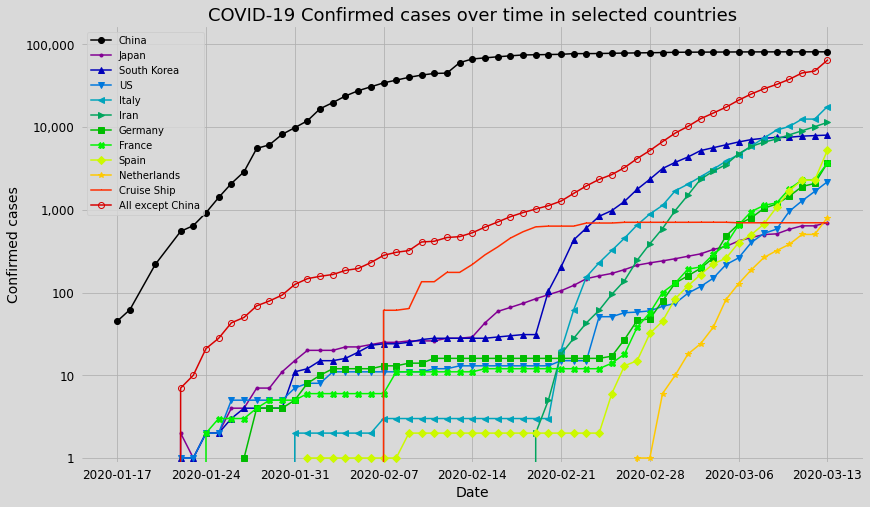

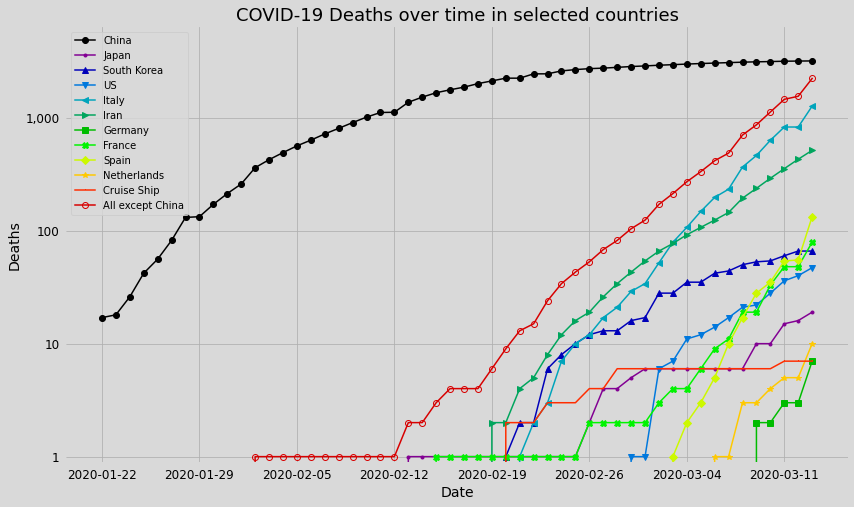

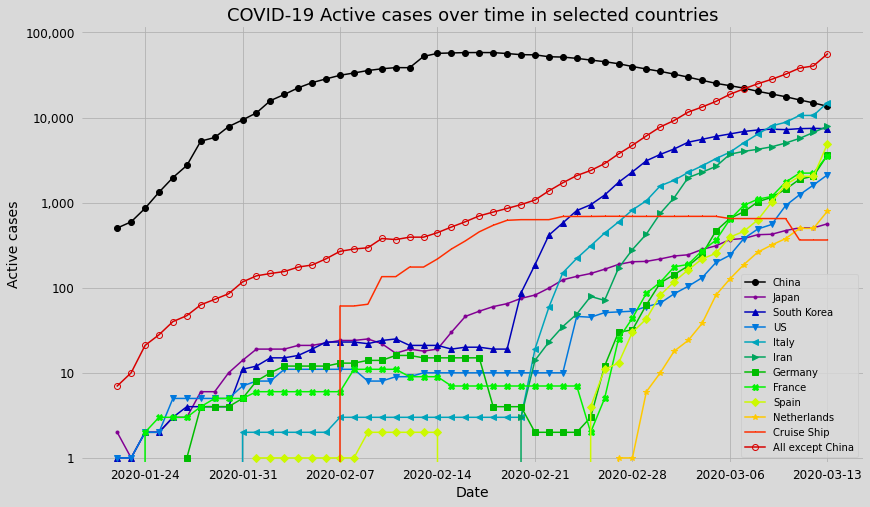

In [33]:
countries_to_plot = ["China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "Cruise Ship", "All except China"]

for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, countries_to_plot)

### Plot cases over days since start of local outbreak in selected countries

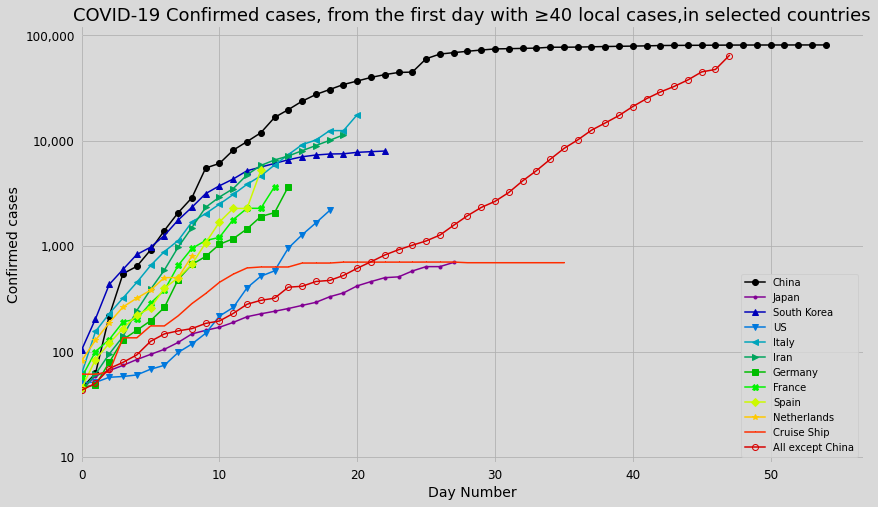

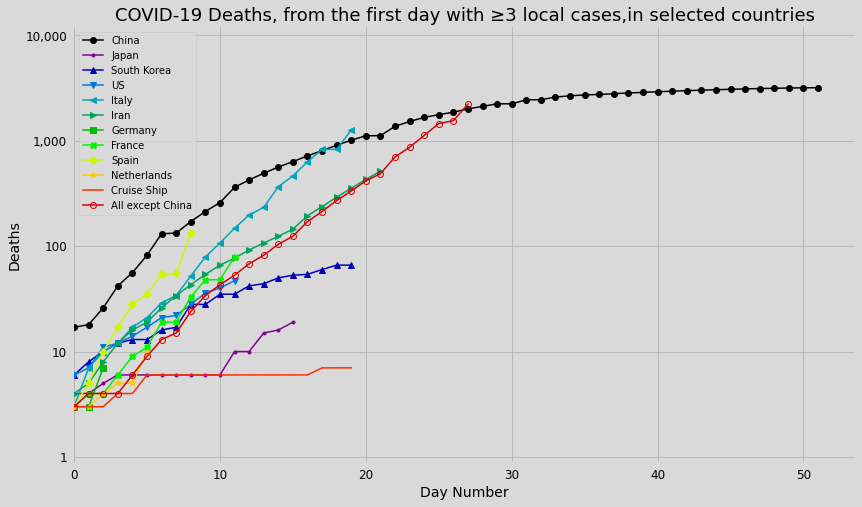

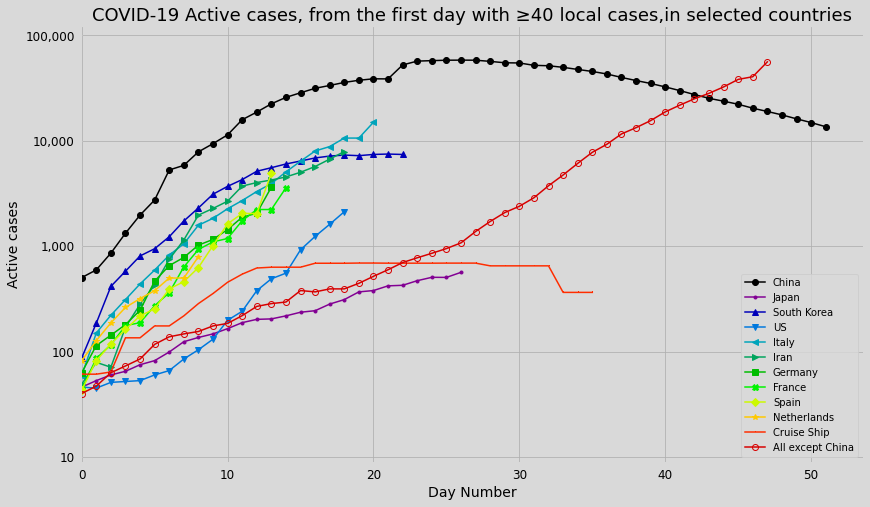

In [34]:
plot("day_number", "confirmed", countries_to_plot, min_cases=40)
plot("day_number", "deaths", countries_to_plot, min_cases=3)
plot("day_number", "active", countries_to_plot, min_cases=40)

### Smoothed growth factor

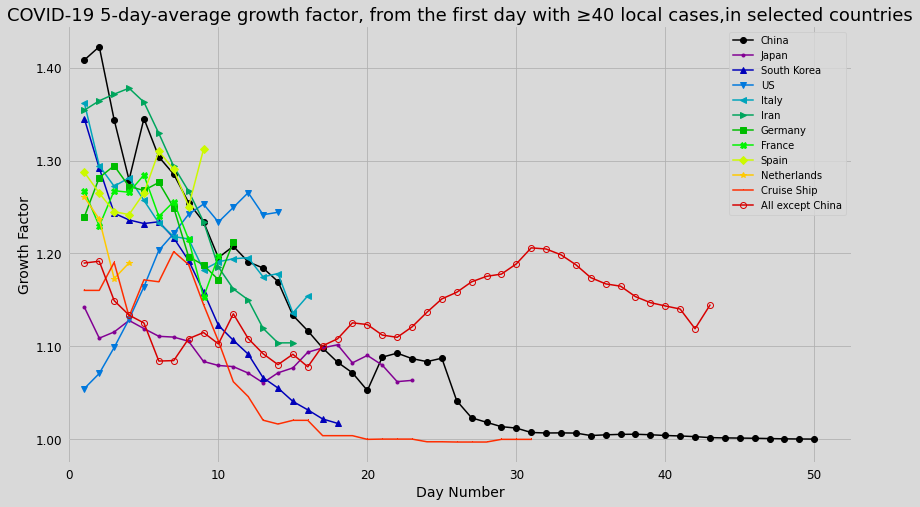

In [35]:
plot("day_number", "growth_factor", countries_to_plot)

### Confirmed cases, deaths and active cases in some other countries

This cell should be relatively easy to experiment in by changing the list of countries, or switching between logarithmic and linear scale.

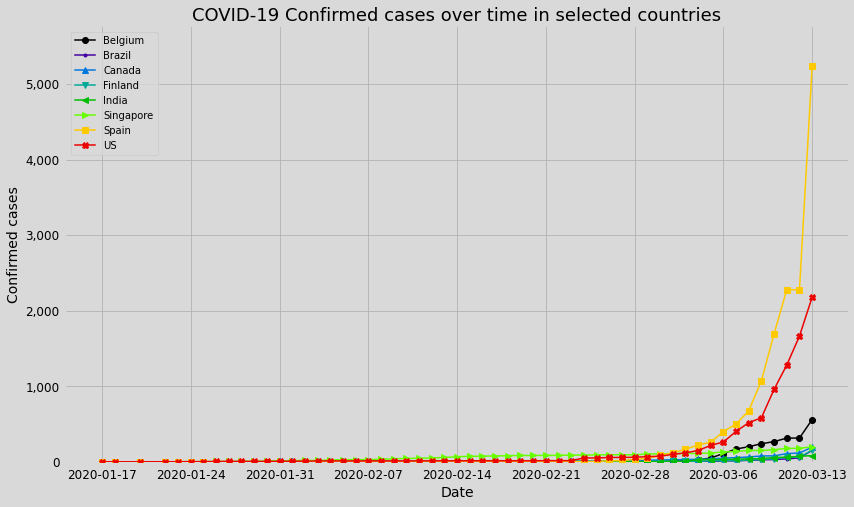

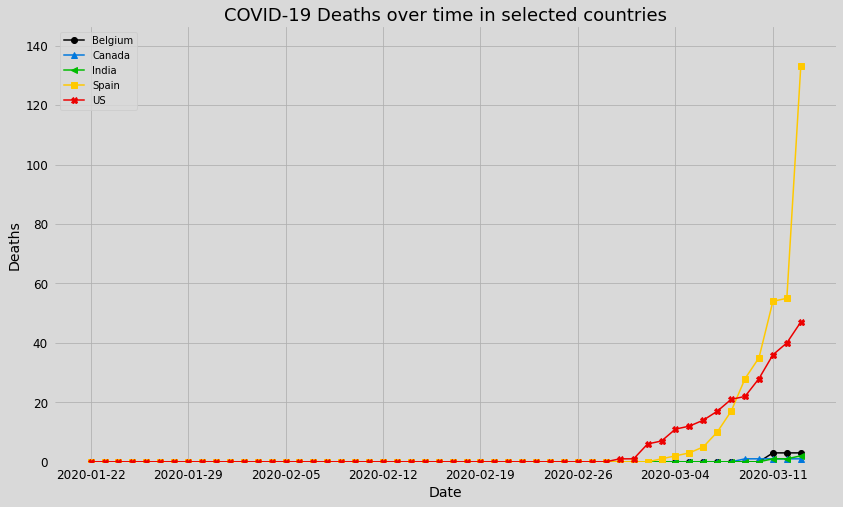

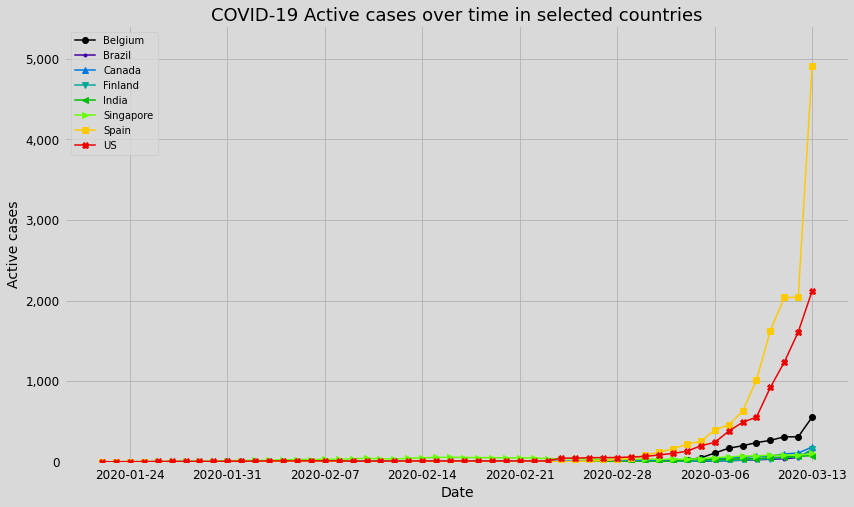

In [36]:
for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Canada", "Finland", "India", "Singapore", "Spain", "US"],
         use_log_scale=False)

### Fit a logistic curve and extrapolate number of future cases

Note that for some countries this looks reasonable, while for some others it can give utter bogus results.

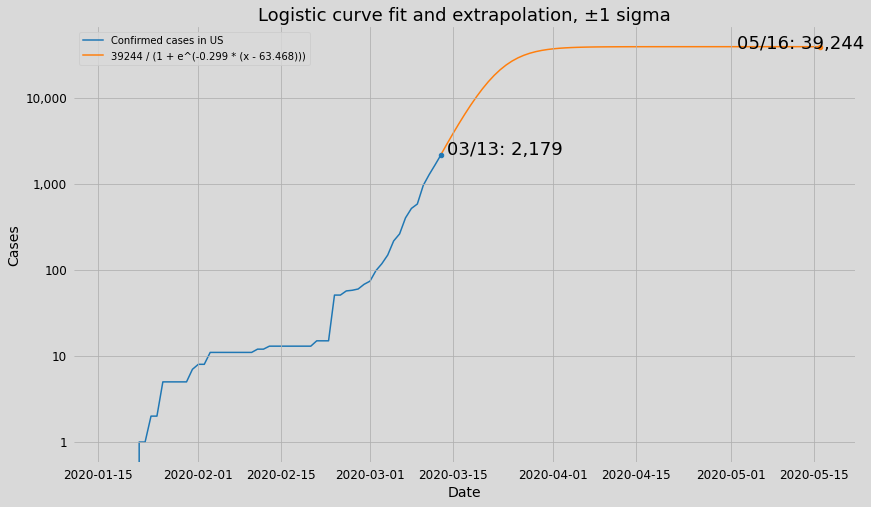

In [48]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def curve_fit(country="All except China", days=100, do_plot=True):
    x = np.arange(days)
    country_data = dataframes["confirmed_by_country"].loc[country, :]
    country_data = country_data[np.isfinite(country_data)]
    current_day = country_data.index[-1]
    
    [L, k, x0], pcov =  scipy.optimize.curve_fit(logistic_func, np.arange(len(country_data)), 
                                                 country_data, maxfev=10000, 
                                                 p0=[1e6, 0.5, max(1, len(country_data))],
                                                 bounds=([0, 0.0, 1], [1e9, 1.0, 200]),
                                                 method="trf"
                                                )

    # dates up to 100 days after start
    model_date_list = [current_day + datetime.timedelta(days = n) for n in range(0, len(x) - len(country_data))] 
    model_date_list = [mdates.date2num(x) for x in model_date_list]

    n = len(model_date_list)
    sig_L, sig_k, sig_x0 = np.sqrt(np.diag(pcov))
    logistic = logistic_func(x[-n:]-1, L, k, x0)
    logistic_sigma = logistic_func(x[-n:]-1, sig_L, sig_k, sig_x0)
    uncertainty_w = np.linspace(0, 1, len(logistic))

    if do_plot:
        plt.plot(country_data, label="Confirmed cases in " + country, markersize=3, zorder=1)
        plt.plot(model_date_list, 
                 logistic, label=f"{L:.0f} / (1 + e^(-{k:.3f} * (x - {x0:.3f})))", zorder=1)

        plt.grid()
        plt.legend(loc="upper left")
        plt.title("Logistic curve fit and extrapolation, ±1 sigma", fontsize=18)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Cases", fontsize=14)
        plt.scatter(mdates.date2num(current_day), country_data[-1], s=20, c="C00", zorder=2)
        plt.annotate(f"{datetime.datetime.strftime(current_day, '%m/%d')}: {country_data[-1]:,.0f}", 
                     (mdates.date2num(current_day)+1, country_data[-1]), fontsize=18)

        plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
        plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {logistic[-1]:,.0f}", 
                     (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
        set_y_axis_format(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.gca().tick_params(which="both", color=light_grey)
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.show()

    return country_data, model_date_list, logistic
    
curve_fit("US", days=120);

## Simulation / Forecast

First, model the probability distribution of dying after a given number of days.

We can consider a case recovered if they survive for a long enough time.

97.00% of being alive after 28 days


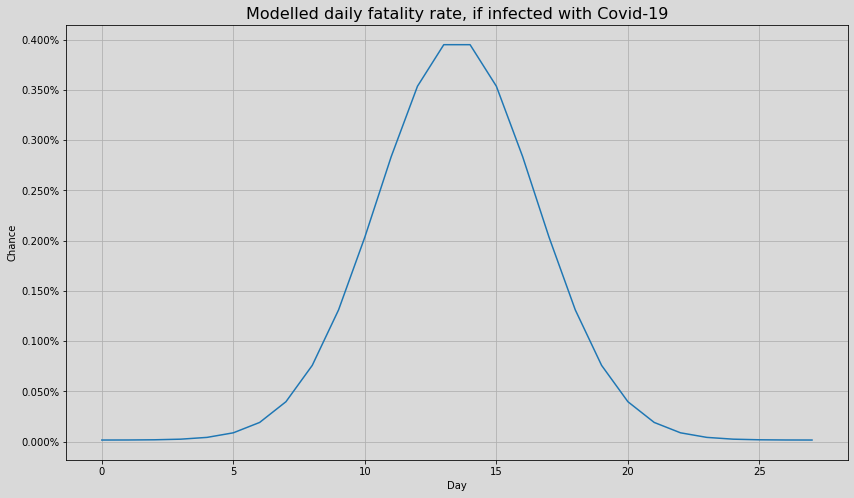

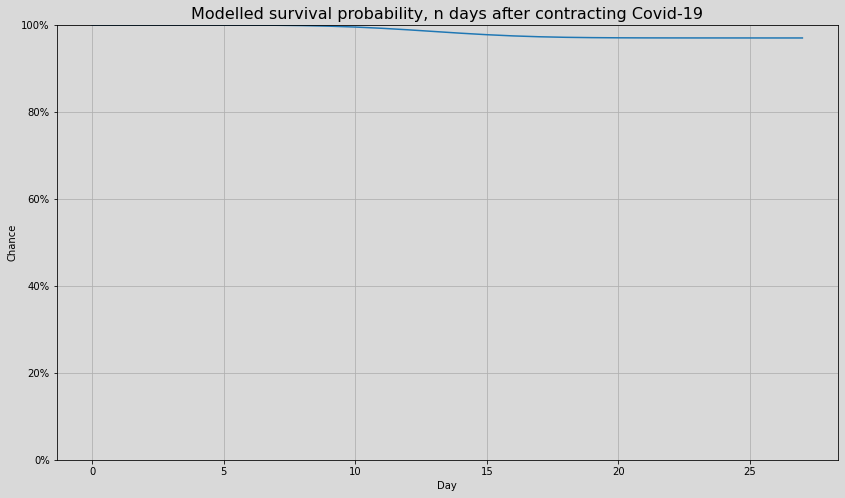

In [38]:
from scipy.signal import gaussian
import matplotlib.ticker as mtick

def normalize_to_target_product(dist, target):
    ratio = np.product(dist)/target
    ratio = ratio ** (1/len(dist))
    dist = dist / ratio
    return dist

def death_chance_per_day(cfr, sigma, length, do_plot):

    # Approximate survival and death odds
    x = np.arange(length)
    death_chance_per_day = gaussian(length, sigma)
    death_chance_per_day = death_chance_per_day/sum(death_chance_per_day) * cfr
    survive_chance_per_day = 1 - death_chance_per_day
        
    # Approximation is slightly off, compensate
    survive_chance_per_day = normalize_to_target_product(survive_chance_per_day, 1-cfr)
    death_chance_per_day = 1 - survive_chance_per_day
    alive = np.product(survive_chance_per_day)

    if do_plot:
        print(f"{alive:.2%} of being alive after {len(x)} days")
        plt.plot(x,100*death_chance_per_day)
        plt.title("Modelled daily fatality rate, if infected with Covid-19", fontsize=16)
        plt.xlabel("Day")
        plt.ylabel("Chance")
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid()
        plt.show()

        plt.plot(x, 100*np.cumprod(survive_chance_per_day))
        plt.title("Modelled survival probability, n days after contracting Covid-19", fontsize=16)
        plt.xlabel("Day")
        plt.ylabel("Chance")
        plt.ylim(0, 100)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid()
        plt.show()
        
    else:
        return death_chance_per_day

death_chance_per_day(cfr=0.03, sigma=3, length=28, do_plot=True)

### Generate history of active cases; how many people have been sick for how long?

Accurate data for how long people have been sick is not available, so it is reconstructed using the assumption that new resolved cases (either death or recovery) always happens to the oldest active cases. In other words, I assume a First-In-First-Out model.

In [39]:
def simulate_country_history(country, population, history_length=28):    
    confirmed = dataframes["confirmed_by_country"].loc[country]
    deaths = dataframes["deaths_by_country"].loc[country]
    recovered = dataframes["recovered_by_country"].loc[country]
    active = confirmed - deaths - recovered
    uninfected = population - confirmed[-1] - deaths[-1] - recovered[-1 ] 
    
    simulation = pd.DataFrame(data=[confirmed, deaths, recovered, active], 
                              index=["confirmed", "deaths", "recovered", "active"]).transpose()
    simulation = simulation.fillna(0)
    
    # reconstruct active case durations by assuming FIFO
    for i, day in enumerate(confirmed.index):
        case_history = [0] * history_length
        if i == 0:
            case_history[0] = simulation.confirmed[0]
        else:
            new_cases     = simulation.confirmed.diff()[i]
            new_deaths    = simulation.deaths.diff()[i]
            new_recovered = simulation.recovered.diff()[i]
            newly_resolved = new_deaths + new_recovered
                        
            case_history[0] = new_cases
            case_history[1:] = simulation.iloc[i-1, -history_length:]
            case_history = case_history[:history_length]

        for h in range(history_length):
            x = history_length - h - 1
            #print(h, x, case_history)
            oldest_active = case_history[x]
            if i != 0 and newly_resolved > 0:  
                if oldest_active >= newly_resolved: 
                    case_history[x] = oldest_active - newly_resolved
                    newly_resolved = 0
                else:
                    newly_resolved -= oldest_active
                    case_history[x] = 0                    

            simulation.at[day.to_datetime64(), f"active_{h}"] = case_history[h]
        
    simulation = simulation.fillna(0).astype(int)
    return simulation
    
display(Markdown("**First 10 days in the US, showing a 7-day case duration history:**"))
display(simulate_country_history(country="US", population=330e6, history_length=7).iloc[:10, :])

**First 10 days in the US, showing a 7-day case duration history:**

,confirmed,deaths,recovered,active,active_0,active_1,active_2,active_3,active_4,active_5,active_6
2020-01-17,0,0,0,0,0,0,0,0,0,0,0
2020-01-18,0,0,0,0,0,0,0,0,0,0,0
2020-01-20,0,0,0,0,0,0,0,0,0,0,0
2020-01-22,1,0,0,1,1,0,0,0,0,0,0
2020-01-23,1,0,0,1,0,1,0,0,0,0,0
2020-01-24,2,0,0,2,1,0,1,0,0,0,0
2020-01-25,2,0,0,2,0,1,0,1,0,0,0
2020-01-26,5,0,0,5,3,0,1,0,1,0,0
2020-01-27,5,0,0,5,0,3,0,1,0,1,0
2020-01-28,5,0,0,5,0,0,3,0,1,0,1


## Simulate future development based on history and probability models

Please note that this is very speculative, and highly dependent on:

* The value chosen for the growth factor. This determines how many people will be infected in the next day of the simulation, relative to the last day. If there are 200 new cases on 3/11 and the growth factor is 1.1, there will be 220 new cases on 3/12. <br><br>The input for growth factor is a list that gets interpolated to the same length as the number of days to simulate. <br><br> For example, simulating 5 days with a growth_rate_trend of `[1.1, 1.0]` will use growth rates of `[1.1, 1.075, 1.05, 1.025, 1.00]`.


* The value chosen for case fatality rate (cfr); evidence so far suggests a range from 0.01 to 0.06


* The number of new cases in the country in the last day

Other limitations of the simulation:

* Doesn't consider incubation time 
* Doesn't have an R0 parameter (uses growth factor instead)
* Doesn't factor in international travel and potential recontamination / second and later waves.

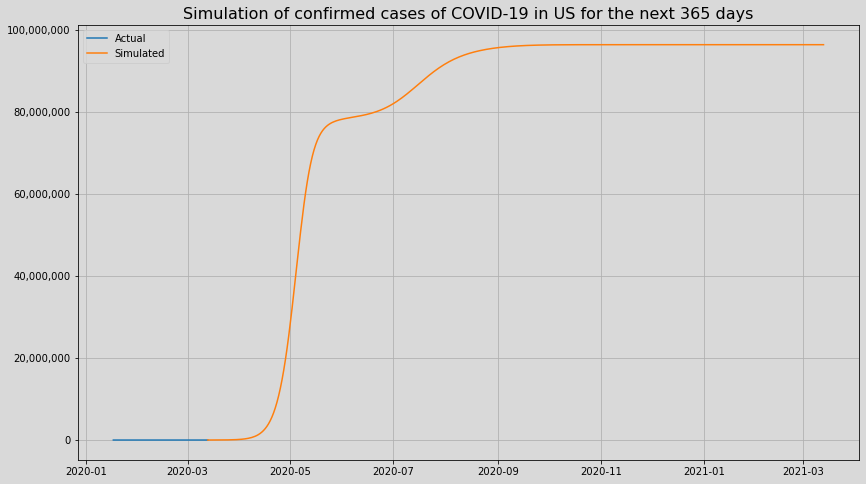

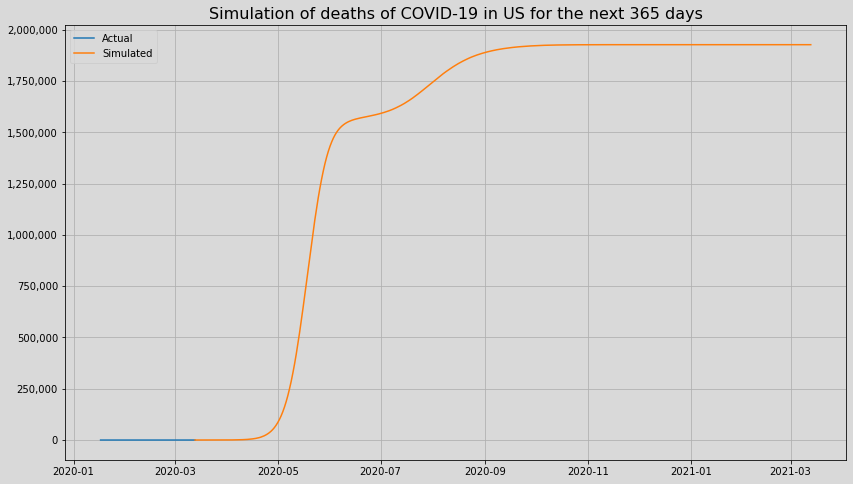

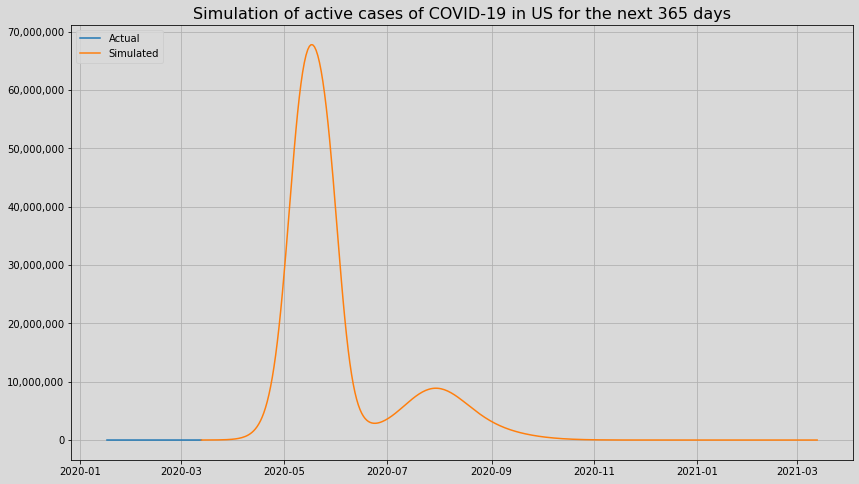

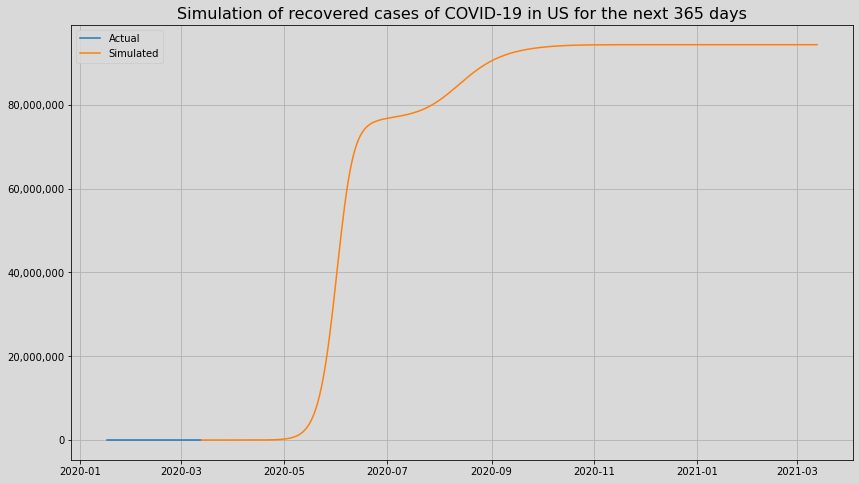

In [40]:
def simulate_country(country,                      # name of the country to simulate
                     population,                   # population of the country
                     days=30,                      # how many days into the future to simulate
                     cfr=0.02,                     # case fatality rate, 0 to 1
                     history_length=28,            # length of case history
                     mean_death_day=14,            # How many days after infection people are most likely to die
                     sigma_death_days=5,           # Standard deviation in mortality over time distribution
                     growth_rate_trend=[1.2, 0.8]  # Trend of growth factor over time. This will be linearly
                                                   # interpolated to a vector of length {days}
                    ):
    growth_rate_per_day = np.interp(np.linspace(0,1,days), 
                                    np.linspace(0,1,len(growth_rate_trend)), 
                                    growth_rate_trend)
                     
    country_history = simulate_country_history(country, population, history_length)
    daily_death_chance = death_chance_per_day(cfr, sigma_death_days, history_length, do_plot=False)
    today = country_history.index[-1]
    
    for d in range(days):        
        # column shortcuts
        confirmed = country_history.confirmed
        deaths = country_history.deaths
        active = country_history.active
        recovered = country_history.recovered
        uninfected = population - confirmed.iloc[-1] - deaths.iloc[-1] - active.iloc[-1] - recovered.iloc[-1]
        case_history = country_history.iloc[-1, -history_length:].copy()
        
        last_day = confirmed.index[-1]
        next_day = last_day + pd.DateOffset(1)
        daily_growth = growth_rate_per_day[d]
        last_delta = confirmed[-1] - confirmed[-2]
        
        
        # infect
        last_confirmed = confirmed.loc[last_day]
        uninfected_ratio = uninfected / (uninfected + active[-1])
        new_cases = int(np.maximum(0, last_delta * daily_growth * uninfected_ratio))
        
        # deaths
        new_deaths = 0
        for case_duration in range(history_length):
            p = daily_death_chance[case_duration]
            deaths_for_duration = np.random.binomial(case_history[case_duration], daily_death_chance[case_duration])
            #print(f"Duration {case_duration}: {case_history[case_duration]} cases, " +\
            #      f"{daily_death_chance[case_duration]:.5%} chance of dying = {deaths_for_duration:.0f} deaths for duration")
            case_history[case_duration] -= deaths_for_duration
            new_deaths += deaths_for_duration
        
        # recover
        new_recovered = case_history[-1]
        
        # uninfected
        uninfected = int(np.maximum(0, uninfected - new_cases - new_deaths - new_recovered))
        
        # shift case history
        case_history[1:] = case_history[:-1]
        case_history.iloc[0] = new_cases
        
        country_history.at[next_day, "confirmed"] = last_confirmed + new_cases
        country_history.at[next_day, "deaths"] = deaths.loc[last_day] + new_deaths
        country_history.at[next_day, "recovered"] = recovered.loc[last_day] + new_recovered
        country_history.at[next_day, "active"] = active.loc[last_day] + new_cases - new_deaths - new_recovered
        country_history.iloc[-1, -history_length:] = case_history
        
    # display(country_history.astype(int))
    
    return country_history, today

country = "US"
days = 365
simulation, today = simulate_country(country=country, population=330e6, days=days, 
                                     growth_rate_trend=[1.25, 1.05, 0.85, 0.75])

for metric in ["confirmed cases", "deaths", "active cases", "recovered cases"]:
    short_metric = metric.split()[0]
    plt.plot(simulation.loc[:today, short_metric], c="C00", label="Actual")
    plt.plot(simulation.loc[today:, short_metric], c="C01", label="Simulated")
    plt.title(f"Simulation of {metric} of COVID-19 in {country} for the next {days} days", fontsize=16)
    set_y_axis_format(False)
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()